# 订阅号系统

此项目实现了一个订阅号系统，功能对照微信的订阅号实现。运行代码前需要先连接校园网（数据库部署在校园网内部的服务器上）。

## 罗列业务需求

本次实习的目标业务是实现类似微信公众号的功能，其核心主要有以下几点：
1. **登录注册更改密码**：实现了基本的用户管理逻辑
2. **查看主页并管理公众号**：用户可以在主页内进行关注和取关公众号的操作，也能查看某公众号的推文内容
3. **显示推文**：用户在主页选择推文点击进去以后，可以查看推文的详细内容以及评论列表
4. **评论以及点赞等交互系统**：用户可以在推文发表评论或者点赞推文，也可以回复或者点赞其他用户的评论（类似论坛）
5. **管理公众号的推文**：公众号由多个用户管理，他们可以增删公众号中的推文

## 数据库设计

设计如下 4 种强实体，并确定其属性
+ 用户（<u>用户ID</u>，用户名，用户密码，注册时间）
+ 公众号（<u>公众号ID</u>，名称）
+ 推文（<u>推文ID</u>，标题，内容，发布公众号，发布时间）
+ 主题（<u>主题ID</u>，类型名称）

评论是依赖于推文的弱实体，其设计如下
+ 评论（<u>推文ID，评论ID</u>，内容，发送时间，发送用户ID，主评论ID，所回复的评论ID）

其中评论分为两种类型，一种是评论推文的根评论，其主评论被设置为NULL，回复的评论也设置为NULL；另一种是评论评论的子评论，子评论在页面显示中位于所属主评论的下方，并且显示所回复评论的部分内容。

接下来列举实体间存在的联系：
+ **订阅**：用户订阅公众号，多对多
+ **创建**：用户创建公众号，一对多
+ **管理**：用户管理公众号，多对多
+ **点赞**：用户点赞推文，多对多
+ **关注**：用户关注主题，多对多
+ **发布**：公众号发布推文，一对多
+ **属于主题**：推文属于某个主题，一对多
+ **评论属于**：评论属于某个推文，一对多
+ **回复**：一条评论被其他评论所回复，一对多
+ **根评论**：一条评论是其他评论的根评论，一对多
+ **点赞**：用户点赞评论，多对多
+ **发送**：用户发送评论，多对多

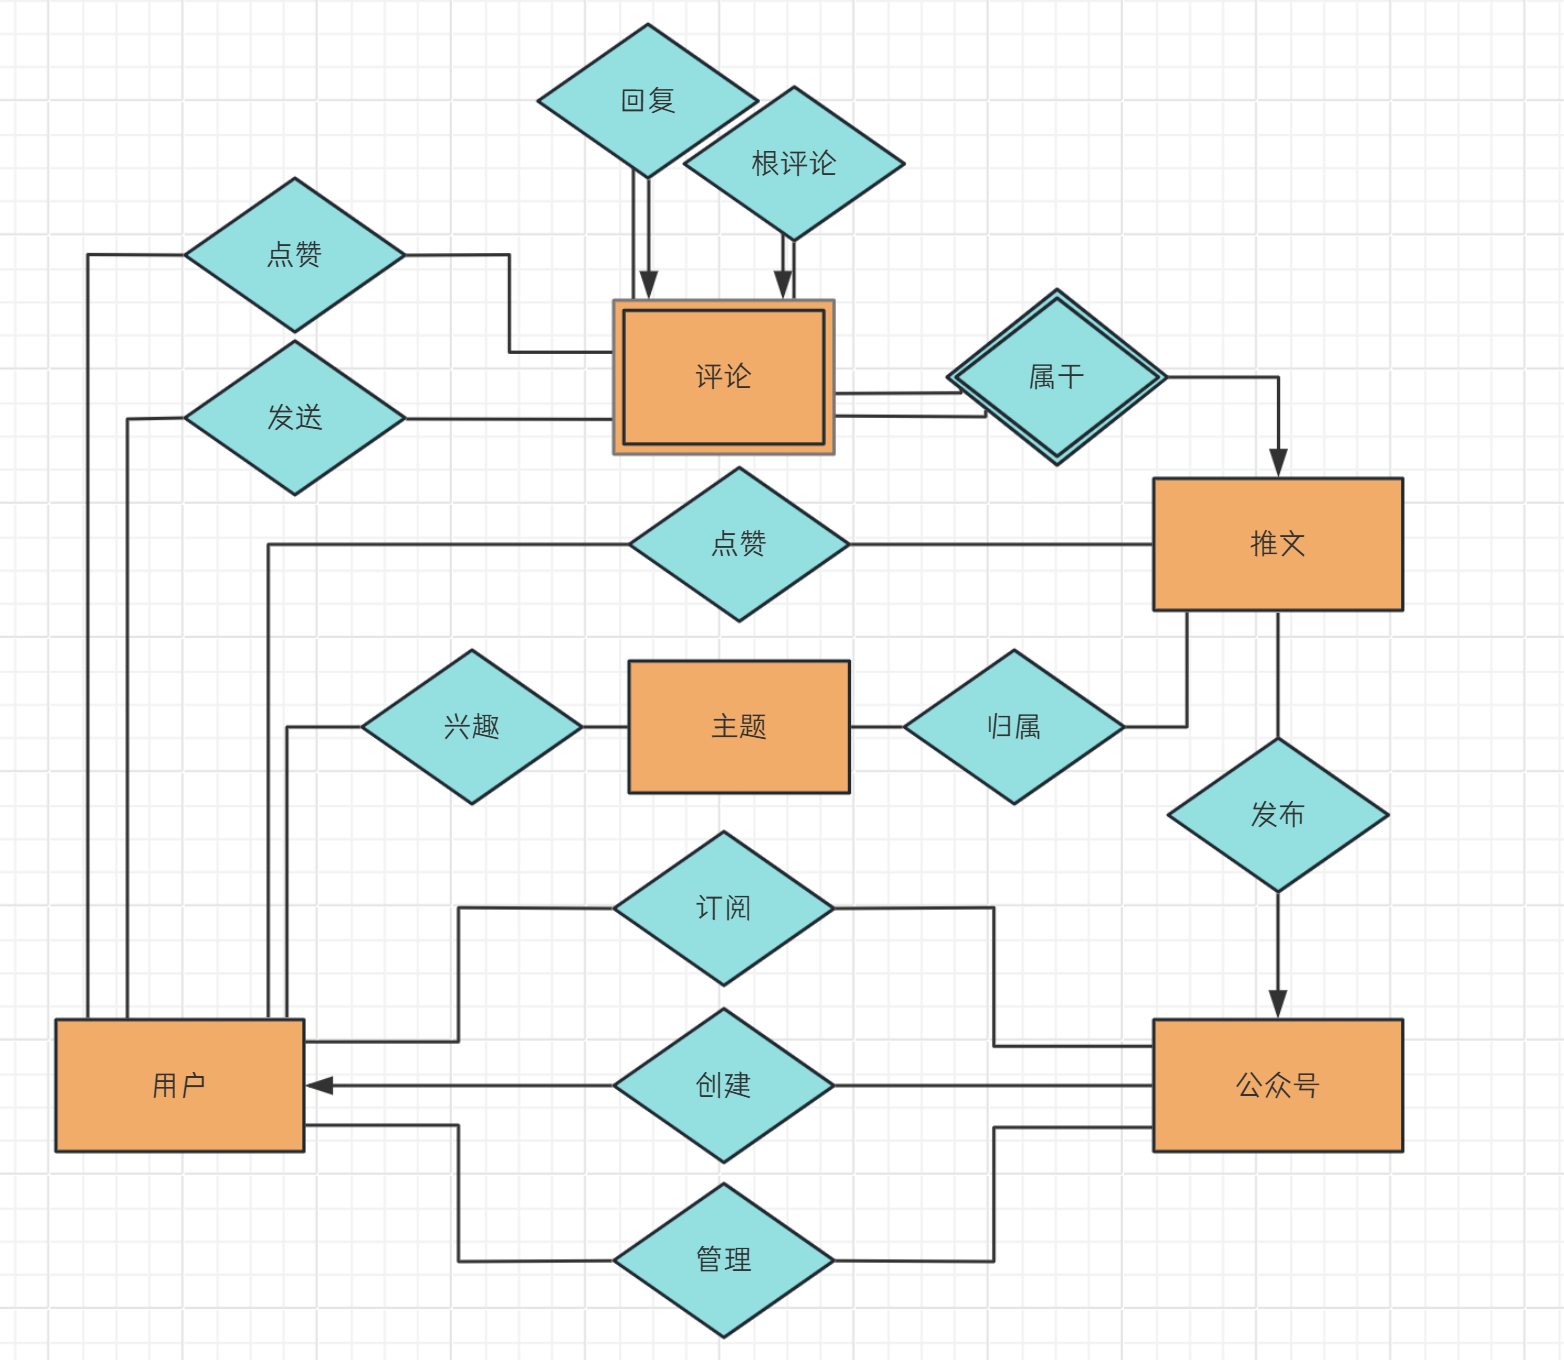

## 关系表设计

把上述的ER图转成关系表结构：

+ **users**: UID, username, password, created_at
+ **channels**: NID, name, created_by, created_at, description
+ **posts**: PID, title, content, created_at, from_channel
+ **comments**: CID, PID, from_user, to_comment, master_comment, content
+ **themes**: TID, type, description
+ **subscribe**: UID, NID
+ **manage_channel**: UID, NID
+ **like_post**: UID, PID
+ **like_comment**: UID, CID, PID
+ **interested_in_theme**: UID, TID
+ **belong_to_theme**: PID, TID

## 创建数据库

按照create_db.py中的内容进行操作，注意运行前需要连接到学校的校园网。

In [ ]:
from create_db import create_db

create_db()

## 数据库操作

列出若干项业务功能（包含增删查改），给出对应的SQL语句。

+ 注册，*登录*，修改密码
+ 列出全部公众号并进行管理（关注或者取消关注）
+ 显示自己所关注的公众号的全部推文
+ 评论某推文或者评论
+ 点赞或者取消点赞某推文或者评论

具体的交互逻辑写在app.py当中，此处仅列举出了部分使用到的SQL语句，在`SQL业务示例.ipynb`中也罗列了部分使用到的SQL语句。

In [ ]:
from create_db import db_config
import pymysql.cursors

# 获取文章信息：pid, title, created_at, like_cnt
with pymysql.connect(**db_config) as connection, connection.cursor(pymysql.cursors.DictCursor) as cursor:
    user_id = 1
    
    cursor.execute(
        """
        WITH post_liker_cnt AS (SELECT lp.pid, COUNT(lp.uid) AS count FROM like_post AS lp GROUP BY lp.pid),
        followed_channels AS (SELECT s.nid FROM subscribe AS s WHERE s.uid = %s)
        SELECT p.pid, p.title, p.created_at, lc.count AS like_cnt
        FROM posts AS p
        JOIN post_liker_cnt AS lc ON p.pid = lc.pid
        WHERE p.from_channel IN (SELECT * FROM followed_channels);
    """,
        (user_id),
    )
    posts = cursor.fetchall()
    print(posts)

In [ ]:
# 获取pid为1的文章的点赞者用户名
with pymysql.connect(**db_config) as connection, connection.cursor() as cursor:
    pid = 1

    cursor.execute(
        """
    SELECT title FROM posts WHERE pid = %s
    """,
        (pid),
    )
    title = cursor.fetchone()[0]

    cursor.execute(
        """
    WITH likers AS (SELECT uid FROM like_post WHERE pid = %s)
    SELECT u.username
    FROM likers AS l
    JOIN users AS u ON l.uid = u.uid;
    """,
        (pid),
    )

    users = cursor.fetchall()
    print(f"赞了\"{title}\"的用户：{', '.join([u[0] for u in users])}")

In [11]:
# 获取post_id为1的文章下的所有评论，并列出全部信息
with pymysql.connect(**db_config) as connection, connection.cursor(cursor=pymysql.cursors.DictCursor) as dictcursor, connection.cursor() as cursor:
    user_name = 'alice'
    post_id = 1
    # 结构化查询评论
    def get_comments(parent_comment_id=None):
        base_query = """
            SELECT c.cid, u.username, c.content, c.master_comment,
            ru.username AS reply_to_user, rc.content AS reply_to_content
            FROM comments c
            LEFT JOIN users u ON c.from_user = u.uid
            LEFT JOIN comments rc ON c.to_comment = rc.cid AND c.pid = rc.pid
            LEFT JOIN users ru ON rc.from_user = ru.uid
            WHERE c.pid = %s
        """
        params = [post_id]

        if parent_comment_id is None:
            base_query += " AND c.master_comment IS NULL"
        else:
            base_query += " AND c.master_comment = %s"
            params.append(parent_comment_id)

        base_query += " ORDER BY c.created_at DESC;"

        dictcursor.execute(base_query, tuple(params))

        comments = []
        for comment in dictcursor.fetchall():
            comment["likers"] = get_comment_likers(comment["cid"])
            comment["liked"] = user_name in comment["likers"]
            if parent_comment_id is None:
                comment["replies"] = get_comments(comment["cid"])
            comments.append(comment)
        return comments

    # 获取评论点赞者
    def get_comment_likers(cid):
        cursor.execute(
            """
            SELECT u.username 
            FROM like_comment lc
            JOIN users u ON lc.uid = u.uid
            WHERE lc.cid = %s AND lc.pid = %s
        """,
            (cid, post_id),
        )
        return [row[0] for row in cursor.fetchall()]

    comments_tree = get_comments()
    print(comments_tree)

[{'cid': 1, 'username': 'bob', 'content': 'Very insightful article on AI!', 'master_comment': None, 'reply_to_user': None, 'reply_to_content': None, 'likers': ['alice', 'charlie', 'eve'], 'liked': True, 'replies': [{'cid': 4, 'username': 'eve', 'content': 'I agree, especially in healthcare applications.', 'master_comment': 1, 'reply_to_user': 'bob', 'reply_to_content': 'Very insightful article on AI!', 'likers': ['david'], 'liked': False}, {'cid': 5, 'username': 'alice', 'content': 'Also in autonomous vehicles!', 'master_comment': 1, 'reply_to_user': 'bob', 'reply_to_content': 'Very insightful article on AI!', 'likers': ['eve'], 'liked': False}, {'cid': 6, 'username': 'bob', 'content': 'Great point about ethics. We need more regulation.', 'master_comment': 1, 'reply_to_user': 'david', 'reply_to_content': 'What about the ethical implications?', 'likers': ['bob'], 'liked': False}]}, {'cid': 2, 'username': 'charlie', 'content': 'I think AI will change everything.', 'master_comment': None,

## 前端web页面开发

执行app.py即可在本地上运行服务器，然后访问`http://127.0.0.1:5000`即可。

In [ ]:
from app import *
app.run(debug=True, use_reloader=False)